# Ejercicio 12: Multimodal Embeddings
## Objetivo de la práctica
El objetivo de este ejercicio es observar cómo modelos multimodales como CLIP llevan texto e imágenes al mismo espacio vectorial, y verificar graficando embeddings en 2D.

### Obtener embeddings de imágenes y textos con CLIP.

In [1]:
pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-29dh5xdi
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-29dh5xdi
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.6 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=0572b8257ef3593c3897ad73783faab08eb3ffe7de139538382c532cfba2defe
  Stored in directory: /tmp/pip-ephem-wheel-cache-1113zx7_/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [12]:
import torch
import clip
from PIL import Image

#Cargar el modelo CLIP y el preprocesador
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device)

#Función para obtener el embedding de texto
def get_text_embedding(text):
    text_input = clip.tokenize([text]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_input)
    return text_features

#Función para obtener el embedding de imagen
def get_image_embedding(image_path):
    image = Image.open(image_path)
    image_input = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image_input)
    return image_features


### Mostrar que ambos viven en el mismo espacio (misma dimensión y comparables).

In [13]:
# Obtener el embedding de texto y de imagen
text = "This is a cat"
image_path = "/content/dataset/cat 1.jpg"

text_embedding = get_text_embedding(text)
image_embedding = get_image_embedding(image_path)

# Concatenar los embeddings de texto e imagen
embeddings = torch.cat([text_embedding, image_embedding], dim=0).cpu().numpy()

# Verificar las dimensiones
print(f"Dimensiones de embedding de texto: {text_embedding.shape}")
print(f"Dimensiones de embedding de imagen: {image_embedding.shape}")


Dimensiones de embedding de texto: torch.Size([1, 512])
Dimensiones de embedding de imagen: torch.Size([1, 512])


### Proyectar los vectores a 2D (PCA / t-SNE / UMAP) y graficarlos en un plano.

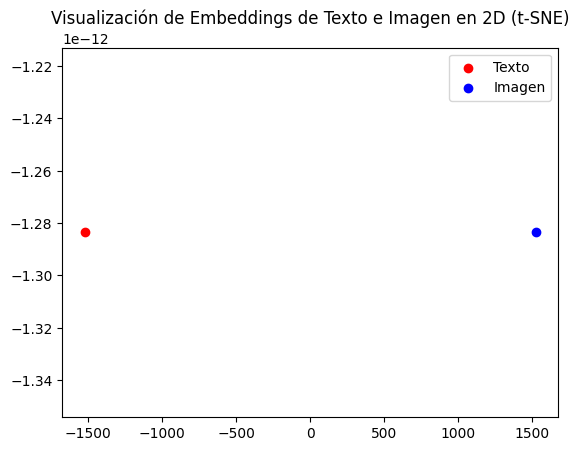

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

#Ajusta la perplexity (por ejemplo, de 30 a 1)
tsne = TSNE(n_components=2, perplexity=1, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

#Graficamos
plt.scatter(embeddings_2d[0, 0], embeddings_2d[0, 1], color='red', label="Texto")
plt.scatter(embeddings_2d[1, 0], embeddings_2d[1, 1], color='blue', label="Imagen")
plt.legend()
plt.title("Visualización de Embeddings de Texto e Imagen en 2D (t-SNE)")
plt.show()


### Verificar emparejamientos usando cosine similarity (búsqueda texto→imagen e imagen→texto).

In [15]:
import torch.nn.functional as F

# Calcular similitud coseno
cosine_sim = F.cosine_similarity(text_embedding, image_embedding)
print(f"Similitud coseno entre el texto y la imagen: {cosine_sim.item()}")


Similitud coseno entre el texto y la imagen: 0.27117735147476196


# Ampliacion del ejercicio

In [16]:
#Importar Librerias
import torch
import numpy as np
from PIL import Image
from transformers import CLIPModel, CLIPProcessor
import os

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


In [22]:
eimage_folder = "dataset"
image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder)]

image_embeddings = []
for path in image_paths:
    emb = get_image_embedding(path)
    image_embeddings.append(emb)

image_embeddings = torch.cat(image_embeddings, dim=0)


### Embeddings

In [23]:
# Embeddings
def get_text_embedding(text):
    inputs = processor(text=[text], return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        embedding = model.get_text_features(**inputs)
    return embedding / embedding.norm(dim=-1, keepdim=True)

def get_image_embedding(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        embedding = model.get_image_features(**inputs)
    return embedding / embedding.norm(dim=-1, keepdim=True)


### Mostrar imagenes

In [24]:
import matplotlib.pyplot as plt

def show_images(images, titles):
    plt.figure(figsize=(10, 4))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(title)
    plt.show()


### Texto a Imagen

In [25]:
# Funcion texto -> imagen
def text_to_image_search(text, top_k=1, show=True):
    text_emb = get_text_embedding(text)

    similarities = (text_emb @ image_embeddings.T).squeeze(0)
    top_indices = similarities.argsort(descending=True)[:top_k]

    results = []
    for idx in top_indices:
        img_path = image_paths[idx]
        score = similarities[idx].item()
        results.append((img_path, score))

        if show:
            img = Image.open(img_path).convert("RGB")
            show_images(
                [img],
                [f"Resultado\nSimilitud: {score:.3f}"]
            )

    return results



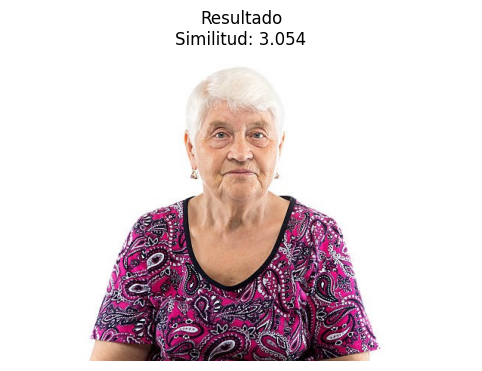

[('dataset/person 3.jpg', 3.054368495941162)]

In [26]:
#Ejemplo de uso
text_to_image_search("the picture of a old lady")

### Imagen a Texto

In [27]:
#Funcion imagen -> texto
def image_to_text(image_path, candidate_texts, show=True):
    image = Image.open(image_path).convert("RGB")
    image_emb = get_image_embedding(image_path)

    text_inputs = processor(
        text=candidate_texts,
        return_tensors="pt",
        padding=True
    ).to(device)

    with torch.no_grad():
        text_embs = model.get_text_features(**text_inputs)

    text_embs = text_embs / text_embs.norm(dim=-1, keepdim=True)

    similarities = (image_emb @ text_embs.T).squeeze(0)
    best_idx = similarities.argmax().item()

    best_text = candidate_texts[best_idx]
    score = similarities[best_idx].item()

    if show:
        show_images(
            [image],
            [f"Imagen de entrada\nPredicción:\n{best_text}\nScore: {score:.3f}"]
        )

    return best_text, score



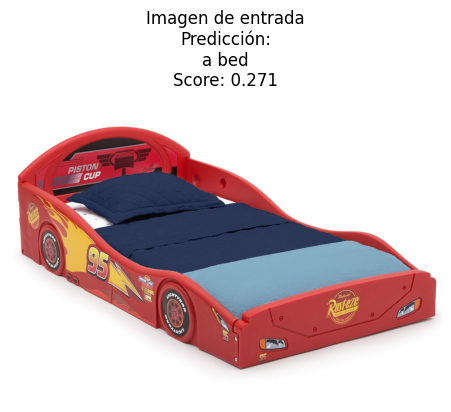

('a bed', 0.2714601755142212)

In [28]:
labels = [
    "a cat",
    "a dog",
    "a car",
    "a bed",
    "a man",
    "a woman"
]

image_to_text("dataset/bed 3.jpg", labels)

## Verificar emparejamientos

### Emparejamiento texto → imagen

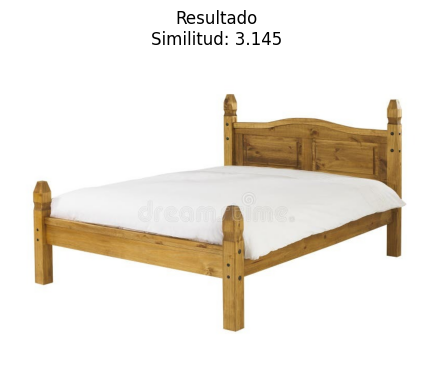

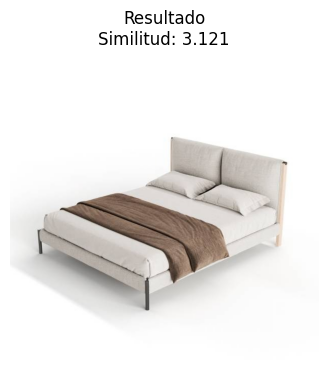

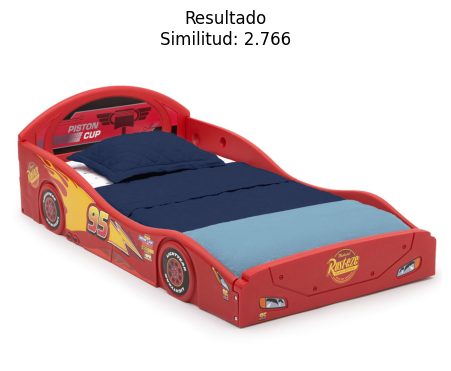

dataset/bed 2.jpg 3.145232677459717
dataset/bed 1.jpg 3.1214470863342285
dataset/bed 3.jpg 2.765589714050293


In [29]:
results = text_to_image_search(
    text="a bed",
    top_k=3,
    show=True
)

for path, score in results:
    print(path, score)


In [ ]:
best_text, score = image_to_text(
    "dataset/bed 3.jpg",
    labels,
    show=True
)

print("Predicción:", best_text)
print("Cosine similarity:", score)

### Emparejamiento imagen → texto

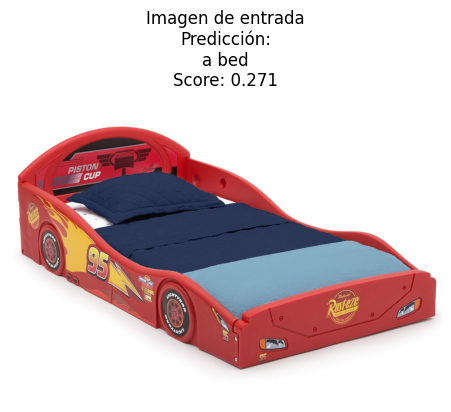

Predicción: a bed
Cosine similarity: 0.2714601755142212


In [30]:
best_text, score = image_to_text(
    "dataset/bed 3.jpg",
    labels,
    show=True
)

print("Predicción:", best_text)
print("Cosine similarity:", score)

### Conclusion

In [32]:
#texto → imagen
results = text_to_image_search("a bed", top_k=1, show=False)
best_image, score_t2i = results[0]

#imagen → texto
best_text, score_i2t = image_to_text(best_image, labels, show=False)

print("Texto original: a bed")
print("Imagen recuperada:", best_image)
print("Texto predicho desde imagen:", best_text)
print("Score texto→imagen:", score_t2i)
print("Score imagen→texto:", score_i2t)

Texto original: a bed
Imagen recuperada: dataset/bed 2.jpg
Texto predicho desde imagen: a bed
Score texto→imagen: 3.145232677459717
Score imagen→texto: 0.30412137508392334
